# Figures 

In [ ]:
import sys
sys.path.insert(0, 'src')

from powerlawdata.solver import silverstein_density, end_pts
from powerlawdata.datasets import load_cifar10, load_mnist, get_dataset

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns 
import torch
from IPython.display import display, Latex

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



power law population density generation

In [3]:
def gen_lambda(M, alpha):
    return torch.diag(torch.tensor([ float(k**(-alpha)) for k in range(1, M+1)], device = device))

## Marcenko-Pastur

In [13]:
def rho_mp_an(lm, lp, z):
    return np.sqrt((lp-z)*(z-lm))/(2*np.pi)/q/z

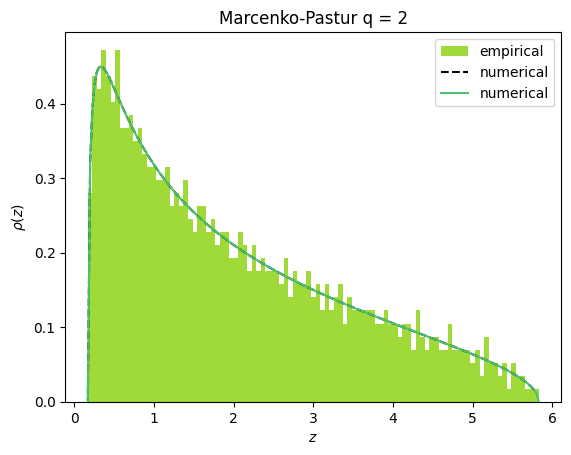

In [31]:
#parameters
q = 2
alpha = 1e-5
lm ,lp = (1-np.sqrt(q))**2, (1+np.sqrt(q))**2
evals  = np.linspace(lp, lm, 200)

#numerical and analytical densities
num_density = silverstein_density(evals , alpha = alpha, q = q, Lc = 1-alpha)
an_density = [rho_mp_an(lm, lp, z) for z in evals]

#empirical
M = 2000
T = int(M/q)

dist = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(M, device = device), gen_lambda(M, alpha))


PSI = dist.sample((T, ))
cov = PSI.T @ PSI /PSI.shape[0]
eigs = sorted(torch.linalg.eigvalsh(cov))[::-1]

sns.set_palette("viridis_r")


plt.hist(eigs, bins = np.linspace(lm, lp, 100), density = True, label = "empirical")
plt.plot(evals, [q*rho for rho in num_density], 'k--', label = "numerical")
plt.plot(evals, [q*rho for rho in an_density], label = "numerical")
plt.xlabel(r"$z$")
plt.ylabel(r"$\rho(z)$")
plt.title("Marcenko-Pastur q = 2")
plt.legend()
plt.show()
#plt.vlines([zL, zR], ymin = 1e-5, ymax = 5e3, linestyle="--", color="tab:green")

## Powerlaw 

In [43]:

#parameters
M = 1000
q = 2
alpha = 1.5
evals = np.logspace(1, -6, 250)

#numerical and analytical densities
num_density = silverstein_density(evals , alpha = alpha, q = q, Lc = M**-alpha)
rho_dict = {}
for z, rho in zip(evals, num_density):
    rho_dict[z] = abs(rho)
zL, zR = end_pts(rho_dict)


#empirical
T = int(M/q)

dist = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(M, device = device), gen_lambda(M, alpha))


PSI = dist.sample((T, ))
cov = PSI.T @ PSI /PSI.shape[0]
eigs = sorted(torch.linalg.eigvalsh(cov))[::-1]

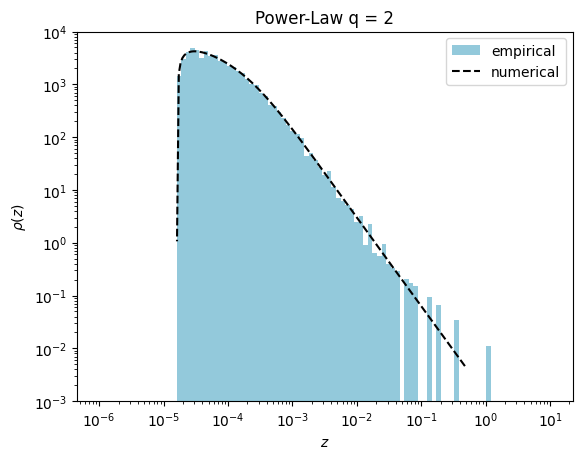

In [45]:
sns.set_palette("ocean_r")


plt.hist(eigs, np.logspace(-6, 1, 100), density = True, label = "empirical")
plt.plot([z for z in rho_dict.keys() if rho_dict[z] is not None and zR >= z >= zL], [q*rho_dict[z] for z in rho_dict.keys() if rho_dict[z] is not None and zR >= z >= zL], 'k--', label = "numerical")
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-3, 1e4)
plt.xlabel(r"$z$")
plt.ylabel(r"$\rho(z)$")
plt.title("Power-Law q = 2")
plt.legend()
plt.show()